# E-Commerce Website A\B Testing
Imagine you own an ecommerce clothing website. You want to test if changing the banner on the website makes more people come in and buy.

## The Columns: What are we looking at?
Think of our dataset (df) as a giant Excel sheet that recorded every single person who walked past your store.
- **user_id**: The Badge Number. Every person gets a unique number.
    - Why it matters: If User #123 walks by twice, we don't want to count them as two different people. We want to know if that specific person bought something.

- **timestamp**: The exact time they walked by. (We aren't using this for now, but usually, you check if weekends are different from weekdays).

- **group**: The Instruction given to the store employee(website administrator).
    - control: "Show this person the Old Banner."
    - treatment: "Show this person the New Banner."

- **landing_page**: The Reality of what the person actually saw.
    - old_page: They saw the Old Banner.
    - new_page: They saw the New Banner.

Wait, aren't group and landing_page the same thing? They should be. But sometimes the employee messes up. (We will get to this in the Crosstab section).

converted: The Result.
- 0: They looked and walked away (No sale).
- 1: They bought a shirt (Sale!).



In [ ]:
#pip install numpy pandas scipy statsmodels matplotlib seaborn jupyter

In [1]:
# 1. Imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

# The Power Analysis (The "Target" vs. The "Reality")

We want to answer: "How many users do we need to prove our hypothesis?"

## The Assumptions:
- Baseline Conversion: 12% (0.12) - Suppose this is the current performance of the store.
- Minimum Detectable Effect: 2% (0.02) - We want to detect if current performance goes up by 14%(We only care if sales go by 2%, say thats our target benchmark of improvement).
- Alpha: 0.05 - 5% chance of false positive.
- Power (1-beta): 0.80 - We want 80% chance of detecting a real difference (We want to be 80% sure of the result)


## Result:
We need at least 4,433 people per group(smaple size), to attain the assumptions we have made. If we test fewer than that, the results are just luck we need enough data for the test.
- Requirement: We need 4,433 people.
- Actual Data: We have 290,000 people.



In [2]:
# 2. Power Analysis
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.12, 0.14)    # Converting from 12% to 14%

# Calculate required sample size
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
)

# Round up to the nearest whole number
required_n = ceil(required_n)

print(f"Required Sample Size per Group: {required_n}")

Required Sample Size per Group: 4433


# Loading & Cleaning

In [8]:
# 3. Load Data
# Assuming you downloaded 'ab_data.csv' from Kaggle into your 'data' folder
df = pd.read_csv('C:\\Users\\tinot\\Desktop\\Projects\\ABTesting_ECommerce_LandingPage\\data\\ab_test.csv')

# Quick look at the top rows
print(df.head())

# Check the structure
print(f"Dataset Shape: {df.shape}")

   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1
Dataset Shape: (294478, 5)


# Sanity Check Crosstab Grid
- A Crosstab is just a grid that checks if two columns match up. We use it to check if the web admins followed instructions.

The Logic:
- If group is Control, the user MUST see the Old Page.
- If group is Treatment, the user MUST see the New Page.

## Results
Control Group
- 145,274 times: The system worked. We wanted them to see the old page, and they did.
- 1,928 times: The system failed. We assigned these people to the "Control" group, but for some reason (bug, glitch), they saw the "New Page."

Treatment Group
- 145,311 times: The system worked. We wanted them to see the new page, and they did.
- 1,965 times: The system failed. We assigned these people to the "Treatment" group, but for some reason (bug, glitch), they saw the "Old Page."

Why this matters: We cannot trust those 1,928/1965 people. We don't know if they bought the shirt because of the "Control" instruction or the "New Page" reality. They are "contaminated" data.

In [9]:
# 4. The Sanity Check (Crucial Step)
# We need to make sure that:
# Group 'control' sees 'old_page'
# Group 'treatment' sees 'new_page'

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Because of the errors we found in the Crosstab, we had to clean the data.
- The Action: We deleted those 1,928 rows and those 1,965 rows.
- The Result: Now, our dataset is "pure."
    - Everyone in Control definitely saw Old Page.
    - Everyone in Treatment definitely saw New Page.

We also removed Duplicate Users. If User #123 visited the site 5 times, we only count their first visit. This prevents one obsessed fan from skewing our data.

In [11]:
# 5. Filter out the Mismatches
# We only want rows where group matches the correct page
df_cleaned = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
]

# Verify the clean (Should be 0 in the off-diagonals now)
print(pd.crosstab(df_cleaned['group'], df_cleaned['landing_page']))

# 6. Check for Duplicate Users
# A user might appear multiple times. We generally want to count unique users.
session_counts = df_cleaned['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f"There are {multi_users} users that appear multiple times in the dataset.")

# Drop duplicates (keeping the first occurrence)
df_cleaned = df_cleaned.drop_duplicates(subset=['user_id'], keep='first')

# Final Check
print(f"Cleaned Dataset Shape: {df_cleaned.shape}")

# Save cleaned data for further analysis
df_cleaned.to_csv('C:\\Users\\tinot\\Desktop\\Projects\\ABTesting_ECommerce_LandingPage\\data\\ab_test_cleaned.csv', index=False)

landing_page  new_page  old_page
group                           
control              0    145274
treatment       145311         0
There are 1 users that appear multiple times in the dataset.
Cleaned Dataset Shape: (290584, 5)


# The "Sample Ratio Mismatch" (SRM) Check
- This is the "Hero" move. Before we look at conversion rates, we check if the split is truly random.
- If we have 50,000 users in A and 50,000 in B, we are good. If we have 50,000 in A and 40,000 in B, STOP. The test is broken.

In [7]:
# 7. Check Traffic Split
print(df_cleaned['group'].value_counts())

# Calculate the ratio
control_count = df_cleaned[df_cleaned['group'] == 'control'].shape[0]
treatment_count = df_cleaned[df_cleaned['group'] == 'treatment'].shape[0]

total_count = control_count + treatment_count
print(f"Control Group Ratio: {control_count / total_count:.4f}")
print(f"Treatment Group Ratio: {treatment_count / total_count:.4f}")

group
treatment    145310
control      145274
Name: count, dtype: int64
Control Group Ratio: 0.4999
Treatment Group Ratio: 0.5001


# Visualizations

C:\Users\tinot\AppData\Local\Temp\ipykernel_35284\168176399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='group', data=df_cleaned, palette='viridis')


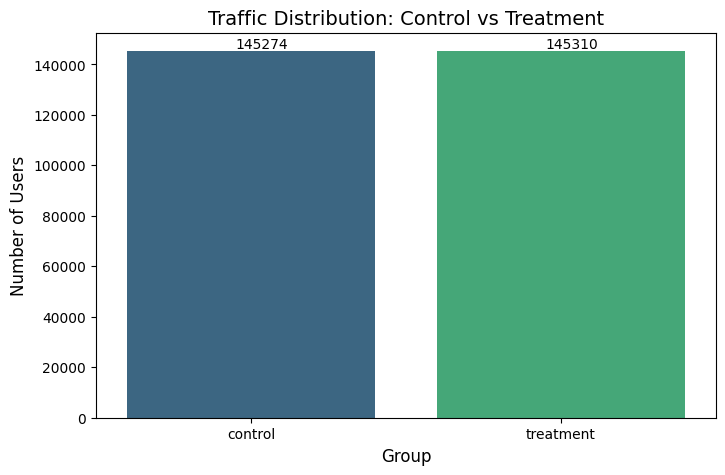

In [12]:
# Visualization 1: The Traffic Split (SRM Check)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='group', data=df_cleaned, palette='viridis')

plt.title('Traffic Distribution: Control vs Treatment', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

# Add the actual numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + 0.35, p.get_height() + 1000))

plt.show()